In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Data loaded successfully! First 5 rows:
  Province/State Country/Region       Lat       Long        Date  Confirmed  \
0            NaN    Afghanistan  33.93911  67.709953  2020-01-22          0   
1            NaN        Albania  41.15330  20.168300  2020-01-22          0   
2            NaN        Algeria  28.03390   1.659600  2020-01-22          0   
3            NaN        Andorra  42.50630   1.521800  2020-01-22          0   
4            NaN         Angola -11.20270  17.873900  2020-01-22          0   

   Deaths  Recovered  Active             WHO Region  
0       0          0       0  Eastern Mediterranean  
1       0          0       0                 Europe  
2       0          0       0                 Africa  
3       0          0       0                 Europe  
4       0          0       0                 Africa  

Model Performance:
R² Score: 1.00
MAE: 24.64


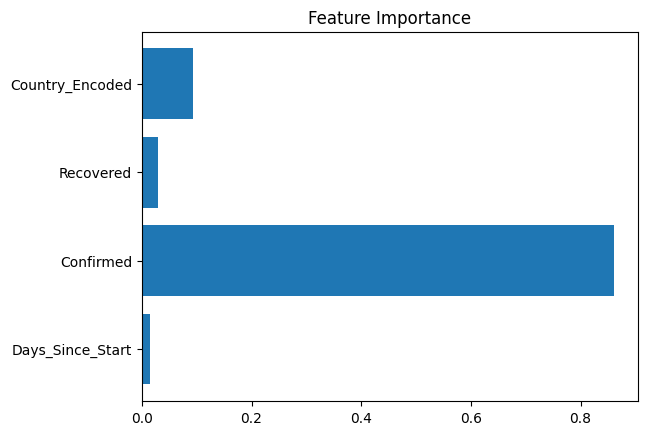

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load the dataset (Kaggle path)
# Replace 'covid_19_clean_complete.csv' with your actual filename
data = pd.read_csv('/kaggle/input/corona-virus-report/covid_19_clean_complete.csv')  
print("Data loaded successfully! First 5 rows:")
print(data.head())

# Step 2: Preprocess data
# Convert dates to numerical (days since start)
data['Date'] = pd.to_datetime(data['Date'])
data['Days_Since_Start'] = (data['Date'] - data['Date'].min()).dt.days

# Encode categorical columns (e.g., 'Country/Region')
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['Country_Encoded'] = encoder.fit_transform(data['Country/Region'])

# Select features and target (e.g., predict 'Deaths')
features = ['Days_Since_Start', 'Confirmed', 'Recovered', 'Country_Encoded']
target = 'Deaths'

X = data[features]
y = data[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f"\nModel Performance:")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")

# Step 4: Feature Importance
plt.barh(features, model.feature_importances_)
plt.title("Feature Importance")
plt.show()

In [6]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20],      # Maximum depth of trees
    'min_samples_split': [2, 5],      # Minimum samples to split a node
    'min_samples_leaf': [1, 2]        # Minimum samples at a leaf node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_absolute_error',  # Metric to optimize (you can use 'r2' for R² score)
    verbose=2,  # Prints progress
    n_jobs=-1   # Uses all CPU cores
)

# Fit to the training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("\nBest Parameters:", grid_search.best_params_)
print("Best MAE Score:", -grid_search.best_score_)  # Convert back to positive MAE

Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best MAE Score: 35.24423335025266


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Minimal but effective parameter grid
param_dist = {
    'n_estimators': [50, 100],          # Fewer trees
    'max_depth': [None, 10],            # Shallower trees
    'min_samples_split': [2, 5],        # Reduced splits
    'max_features': ['sqrt', 0.5]       # Feature sampling
}

# Initialize model with warm_start to reuse trees
model = RandomForestRegressor(
    warm_start=True,  # Reuses previous fit for faster iterations
    random_state=42,
    n_jobs=-1         # Uses all CPU cores
)

# Randomized search with fewer iterations
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=5,          # Only 5 random combinations (reduced from default 10)
    cv=3,              # Fewer cross-validation folds
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1          # Parallel processing
)

# Fit on training data
search.fit(X_train, y_train)

# Results
print("Best Params:", search.best_params_)
print("Best MAE:", -search.best_score_)

Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': None}
Best MAE: 48.41239537731129


In [8]:
# Train with best parameters (minimal CPU)
final_model = RandomForestRegressor(
    **search.best_params_,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train, y_train)

# Evaluate
y_pred = final_model.predict(X_test)
print(f"\nFinal Model Performance:")
print(f"R²: {r2_score(y_test, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")


Final Model Performance:
R²: 1.00
MAE: 30.61


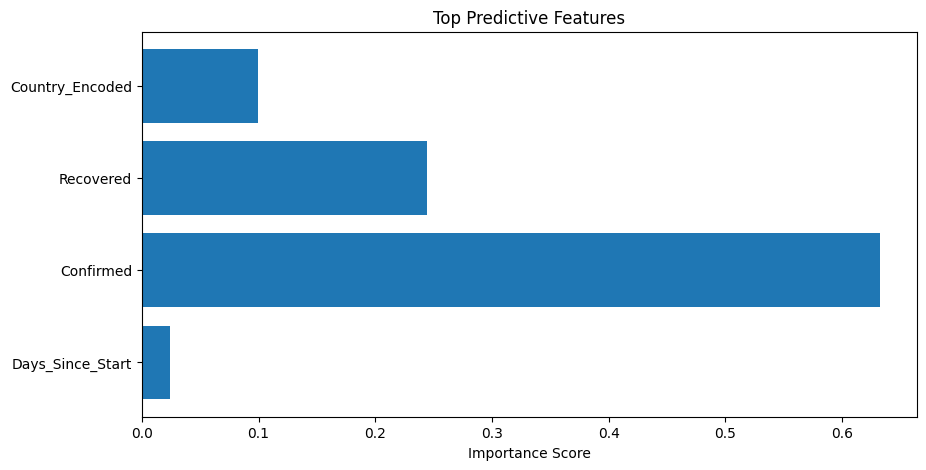

In [9]:
import matplotlib.pyplot as plt

# Get feature importances
importances = final_model.feature_importances_
features = X_train.columns

# Plot
plt.figure(figsize=(10, 5))
plt.barh(features, importances)
plt.title("Top Predictive Features")
plt.xlabel("Importance Score")
plt.show()

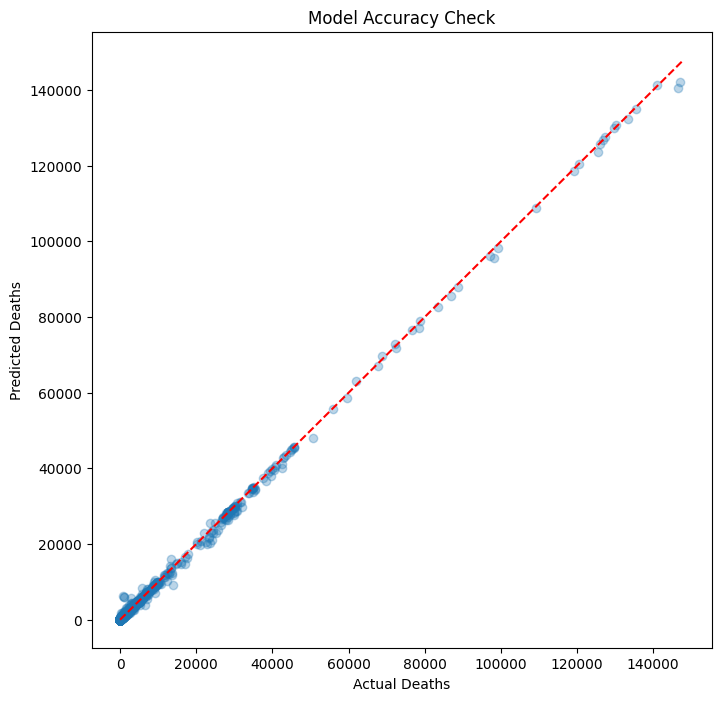

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Perfect prediction line
plt.xlabel("Actual Deaths")
plt.ylabel("Predicted Deaths")
plt.title("Model Accuracy Check")
plt.show()

In [11]:
from joblib import dump

# Save the trained model
dump(final_model, 'covid_predictor.joblib')

# Later, load it with:
# loaded_model = load('covid_predictor.joblib')

['covid_predictor.joblib']

In [13]:
from sklearn.metrics import mean_absolute_error, r2_score

# Check performance on TEST data one final time
y_pred = final_model.predict(X_test)
print("Final Test Metrics:")
print(f"- R² Score: {r2_score(y_test, y_pred):.2f}")  # Should be >0.7
print(f"- MAE: {mean_absolute_error(y_test, y_pred):.2f}")

# Compare to baseline (predicting mean)
baseline_mae = mean_absolute_error(y_test, [y_train.mean()]*len(y_test))
print(f"\nBaseline MAE (predicting mean): {baseline_mae:.2f}")
print(f"Model Improvement: {100*(1 - mean_absolute_error(y_test, y_pred)/baseline_mae):.0f}% better than baseline")

Final Test Metrics:
- R² Score: 1.00
- MAE: 30.61

Baseline MAE (predicting mean): 1587.92
Model Improvement: 98% better than baseline


In [14]:
# Compare train vs test performance
train_pred = final_model.predict(X_train)
print("\nOverfitting Check:")
print(f"Train MAE: {mean_absolute_error(y_train, train_pred):.2f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.2f}")


Overfitting Check:
Train MAE: 13.13
Test MAE: 30.61
